In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import requests
import pickle
from scipy import sparse
from collections import Counter

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [2]:
# CONVENIENT FUNCTION FOR SELECTING SUBSETS

def select( df, column , operator , value):
    if operator ==  "equals":
        return df[df[column]==value]
    elif operator == "contains":
        return df[[(value.lower() in str(title).lower()) for title in df[column]]]
    elif operator ==  "gt":
        return df[df[column] > value]
    elif operator ==  "ge":
        return df[df[column] >= value]
    elif operator ==  "lt":
        return df[df[column] <= value]
    elif operator ==  "le":
        return df[df[column] <= value]
    

# CONVENIENT FUNCTION FOR SELECTING SUBSETS - AS A CLASS OBJECT
# BM - Boolean Masking
class BM:
    def  __init__(self,df):
        self.df= df
    
    def select( self, column , operator , value):
        if operator ==  "equals":
            return BM(self.df[self.df[column]==value])
        elif operator == "contains":
            return BM(self.df[[(value.lower() in str(title).lower()) for title in self.df[column]]])
        elif operator ==  "gt":
            return BM(self.df[self.df[column] > value])
        elif operator ==  "ge":
            return BM(self.df[self.df[column] >= value])
        elif operator ==  "lt":
            return BM(self.df[self.df[column] <= value])
        elif operator ==  "le":
            return BM(self.df[self.df[column] <= value])

# DoL DATA SETUP 


## IMPORT DATA FROM DoL

In [3]:
## REMOVE COMMENT TO IMPORT DATABASE FROM DoL
#
#!curl -O https://www.onetcenter.org/dl_files/database/db_23_2_excel.zip
#!unzip db_23_2_excel.zip
#!ls

In [4]:
##Import Content Model Reference and Alternative Job title database 
#!curl -O https://www.onetcenter.org/dl_files/database/db_23_2_excel/Content%20Model%20Reference.xlsx
#!curl -O https://www.onetcenter.org/dl_files/database/db_23_2_excel/Alternate%20Titles.xlsx

In [5]:
!ls

#                                DoL Data Setup.ipynb
Alternate%20Titles.xlsx          db_23_2_excel
Content%20Model%20Reference.xlsx db_23_2_excel.zip


In [6]:
# Import the abilities table
dab = pd.read_excel('db_23_2_excel/Abilities.xlsx')

In [7]:
# IMPORT THE DATADICTIONARY chapters of interest
onet = {}
onet['Abilities']=pd.read_excel('db_23_2_excel/Abilities.xlsx')
onet['Model Reference'] = pd.read_excel('db_23_2_excel/Content Model Reference.xlsx')
onet['Alternate Titles'] = pd.read_excel('db_23_2_excel/Alternate Titles.xlsx')
onet['Work Context']=pd.read_excel('db_23_2_excel/Work Context.xlsx')
onet['Work Context Categories']=pd.read_excel('db_23_2_excel/Work Context Categories.xlsx')

In [8]:
# Short names:
dab = onet['Abilities']
dct = onet['Alternate Titles']
dcm = onet['Model Reference']
dwc = onet['Work Context']
dwcc = onet['Work Context Categories']

## THE ABILITIES DATABASE

In [9]:
dab.sample(5)

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
34023,25-2011.00,"Preschool Teachers, Except Special Education",1.A.1.b.4,Deductive Reasoning,LV,Level,3.25,8.0,0.16,2.93,3.57,N,N,06/2010,Analyst
65998,43-4141.00,New Accounts Clerks,1.A.3.a.1,Static Strength,IM,Importance,1.00,8.0,0.00,1.00,1.00,N,NaN,07/2011,Analyst
46718,29-2011.02,Cytotechnologists,1.A.1.c.1,Mathematical Reasoning,IM,Importance,2.62,8.0,0.18,2.27,2.98,N,NaN,07/2014,Analyst
97323,53-4041.00,Subway and Streetcar Operators,1.A.4.a.2,Far Vision,LV,Level,3.50,8.0,0.50,2.52,4.48,N,N,12/2006,Analyst
82906,49-9094.00,Locksmiths and Safe Repairers,1.A.1.b.6,Information Ordering,IM,Importance,3.50,8.0,0.19,3.13,3.87,N,NaN,06/2010,Analyst


### SELECT ABILITY METRICS

For each occupation, each ability is weighted by two metrics: 'LEVEL' and 'IMPORTANCE'. As shown below, they are nearly proportional. 

Combining them, ```Weight = Sqrt(Level * Importance)```, reduces the size of the data and simplifies further processing. 

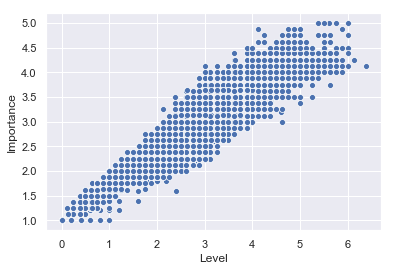

In [10]:

lvim = pd.DataFrame(np.array([select(dab,'Scale Name','equals','Level')['Data Value'].values,select(dab,'Scale Name','equals','Importance')['Data Value'].values]))
lvim = lvim.T
lvim.columns = ['Level','Importance']
lvim['Weight'] = np.sqrt(lvim['Level'] * lvim['Importance'])
sns.scatterplot(x='Level',y='Importance',data=lvim)

In [11]:
dab0 = dab.copy()
dab0['socc+ID'] = dab0['O*NET-SOC Code'] +' '+ dab0['Element ID']
dab1 = select(dab0,'Scale Name','equals','Importance').set_index('socc+ID')
dab2 = select(dab0,'Scale Name','equals','Level').set_index('socc+ID')
dab1['Weight'] = np.sqrt(dab1['Data Value']*dab2['Data Value']).round(2)
dab1['Importance'] = dab1['Data Value']
dab1.drop(['Scale ID','Scale Name', 'Data Value', 'N', 'Standard Error', 'Lower CI Bound',
       'Upper CI Bound', 'Recommend Suppress', 'Not Relevant', 'Date','Domain Source'],axis=1, inplace=True)
dab1['Level'] = dab2['Data Value']

In [12]:
#Control that dabr is OK by comparing with dab
dab1.head(10)

,O*NET-SOC Code,Title,Element ID,Element Name,Weight,Importance,Level
socc+ID,,,,,,,
11-1011.00 1.A.1.a.1,11-1011.00,Chief Executives,1.A.1.a.1,Oral Comprehension,4.69,4.50,4.88
11-1011.00 1.A.1.a.2,11-1011.00,Chief Executives,1.A.1.a.2,Written Comprehension,4.43,4.25,4.62
11-1011.00 1.A.1.a.3,11-1011.00,Chief Executives,1.A.1.a.3,Oral Expression,4.68,4.38,5.00
11-1011.00 1.A.1.a.4,11-1011.00,Chief Executives,1.A.1.a.4,Written Expression,4.36,4.12,4.62
11-1011.00 1.A.1.b.1,11-1011.00,Chief Executives,1.A.1.b.1,Fluency of Ideas,4.23,3.88,4.62
11-1011.00 1.A.1.b.2,11-1011.00,Chief Executives,1.A.1.b.2,Originality,4.06,3.88,4.25
11-1011.00 1.A.1.b.3,11-1011.00,Chief Executives,1.A.1.b.3,Problem Sensitivity,4.47,4.00,5.00
11-1011.00 1.A.1.b.4,11-1011.00,Chief Executives,1.A.1.b.4,Deductive Reasoning,4.54,4.12,5.00
11-1011.00 1.A.1.b.5,11-1011.00,Chief Executives,1.A.1.b.5,Inductive Reasoning,4.47,4.00,5.00


### CONTEXTUAL COOLABILITIES
For Sewing Machine Operators, people with hearing difficulties have a 'contextual coolability' - they are insensitive to the noisy environment. This ability is not present in the ability - taxonomy. As a result, the variance will be projected on other abilities. 

We can compensate for this by including the ONET table for "WORK CONTEXT", which may be translated into abilities, relating to coolabilities, by some standardized procedure.  

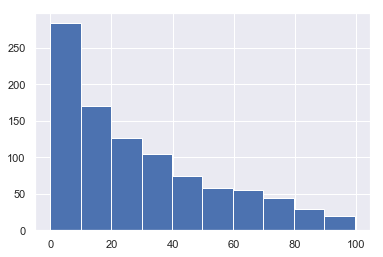

In [13]:
BM(dwc).select('Category','equals',5
          ).select('Element Name','equals','Sounds, Noise Levels Are Distracting or Uncomfortable').df['Data Value'].hist()

### CALCULATE MEANS AND STANDARD DEVIATIONS OF VARIABLES, FOR THE PURPOSE OF NORMALIZING

#### ABILITIES

In [14]:
abilities = dab1
abilities_stats = dab1.groupby('Element ID').count()[['Weight']]
abilities_stats['min'] = dab1.groupby('Element ID').min()['Weight']
abilities_stats['max'] = dab1.groupby('Element ID').max()['Weight']
abilities_stats['mean'] = dab1.groupby('Element ID').mean()['Weight']
abilities_stats['std'] = dab1.groupby('Element ID').std()['Weight']
abilities_stats['skew'] = dab1.groupby('Element ID').skew()['Weight']
abilities_stats = abilities_stats.reset_index()

######################### TEMPORARY NORMALIZATIONS - FIX THIS!!! ###############################
abilities['Normal Weight'] = (abilities['Weight']-abilities_stats.mean()['mean'])/abilities_stats.mean()['std'] 

In [15]:
abilities.sample(5)

,O*NET-SOC Code,Title,Element ID,Element Name,Weight,Importance,Level,Normal Weight
socc+ID,,,,,,,,
47-4071.00 1.A.1.f.1,47-4071.00,Septic Tank Servicers and Sewer Pipe Cleaners,1.A.1.f.1,Spatial Orientation,2.43,2.62,2.25,0.244765
25-2053.00 1.A.1.e.3,25-2053.00,"Special Education Teachers, Middle School",1.A.1.e.3,Perceptual Speed,2.49,2.75,2.25,0.325514
43-9011.00 1.A.1.a.2,43-9011.00,Computer Operators,1.A.1.a.2,Written Comprehension,3.56,3.38,3.75,1.765539
21-1015.00 1.A.1.b.2,21-1015.00,Rehabilitation Counselors,1.A.1.b.2,Originality,3.24,3.00,3.50,1.334877
17-1022.01 1.A.1.d.1,17-1022.01,Geodetic Surveyors,1.A.1.d.1,Memorization,2.94,2.88,3.00,0.931132


#### CONTEXTS 
For simplicity - consider only contexts of the highest category (5)

In [16]:
contexts = dwc
contexts_stats = BM(dwc).select('Category','equals',5).df.groupby('Element ID').count()[['Data Value']]
contexts_stats['min'] =  BM(dwc).select('Category','equals',5).df.groupby('Element ID').min()['Data Value']
contexts_stats['max'] =  BM(dwc).select('Category','equals',5).df.groupby('Element ID').max()['Data Value']
contexts_stats['mean'] =  BM(dwc).select('Category','equals',5).df.groupby('Element ID').mean()['Data Value']
contexts_stats['std'] =  BM(dwc).select('Category','equals',5).df.groupby('Element ID').std()['Data Value']
contexts_stats['skew'] =  BM(dwc).select('Category','equals',5).df.groupby('Element ID').skew()['Data Value']
contexts_stats.head()

######################### TEMPORARY NORMALIZATIONS - FIX THIS!!! ###############################
contexts['Normal Weight'] = (contexts['Data Value']-contexts_stats.mean()['mean'])/contexts_stats.mean()['std']


contexts.sample(5)

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source,Normal Weight
218282,43-5052.00,Postal Service Mail Carriers,4.C.2.d.1.g,"Spend Time Using Your Hands to Handle, Control...",CX,Context,NaN,4.18,45.0,0.27,3.63,4.73,N,NaN,07/2016,Incumbent,-1.016476
180762,35-3011.00,Bartenders,4.C.2.d.1.f,Spend Time Keeping or Regaining Balance,CXP,Context (Categories 1-5),4.0,7.25,24.0,7.11,0.87,41.09,N,NaN,07/2017,Incumbent,-0.852867
14347,11-9121.02,Water Resource Specialists,4.C.2.b.1.e,"Cramped Work Space, Awkward Positions",CXP,Context (Categories 1-5),1.0,42.86,28.0,NaN,NaN,NaN,NaN,NaN,07/2012,Occupational Expert,1.044897
68834,17-3029.09,Manufacturing Production Technicians,4.C.2.c.1.d,Exposed to Hazardous Conditions,CXP,Context (Categories 1-5),2.0,30.43,23.0,NaN,NaN,NaN,NaN,NaN,07/2017,Occupational Expert,0.382465
7327,11-3111.00,Compensation and Benefits Managers,4.C.2.d.1.f,Spend Time Keeping or Regaining Balance,CXP,Context (Categories 1-5),1.0,90.48,21.0,NaN,NaN,NaN,NaN,NaN,07/2017,Occupational Expert,3.582710


# TRANSLATE CENSUS PROFILES INTO ABILITY PROFILES

## 2ND ATTEMPT: RELATIVE OCCUPATION STATISTICS.

## 1ST ATTEMPT: MEDIAN WAGE COMPARISON. RESULT - TOO POOR SIGNAL
**HYPOTHESIS: WAGES ARE A BAD INDICATOR FOR ABILITIES** 

### IMPORT THE DEAR/DEYE - MEDIAN WAGE STATS FROM CENSUS

In [17]:
dear = pd.read_pickle('../census/deartops.pkl').reset_index()
deye = pd.read_pickle('../census/deyetops.pkl').reset_index()

In [18]:
dear.head()

,index,SOCP,Occupation,FTE relative,dear-FTE USmean,count,all count,relative count
0,151,291060,MED-Physicians And Surgeons,0.94,153735.0,539,42792,0.012596
1,150,291051,MED-Pharmacists,0.96,110303.0,151,11972,0.012613
2,48,132052,FIN-Personal Financial Advisors,1.28,102740.0,216,14506,0.014890
3,17,119041,MGR-Architectural And Engineering Managers,0.95,102199.0,130,7372,0.017634
4,114,2310XX,"LGL-Lawyers, And Judges, Magistrates, And Othe...",1.02,100956.0,794,47817,0.016605


#### NORMALIZE THE KEY VARIABLE "FTE relative"

In [19]:
dear.sort_values(['FTE relative','dear-FTE USmean'],ascending=False)

,index,SOCP,Occupation,FTE relative,dear-FTE USmean,count,all count,relative count
2,48,132052,FIN-Personal Financial Advisors,1.28,102740.0,216,14506,0.014890
30,176,299000,MED-Other Healthcare Practitioners And Technic...,1.26,65226.0,118,4596,0.025674
40,35,131081,BUS-Logisticians,1.24,60790.0,128,5364,0.023863
154,207,352021,EAT-Food Preparation Workers,1.24,34782.0,111,6656,0.016677
155,469,537064,"TRN-Packers And Packagers, Hand",1.21,34742.0,176,7537,0.023351
13,69,171010,"ENG-Architects, Except Naval",1.19,81644.0,113,7378,0.015316
102,216,371011,CLN-First-Line Supervisors Of Housekeeping And...,1.19,44414.0,182,6843,0.026597
136,383,512020,"PRD-Electrical, Electronics, And Electromechan...",1.19,37927.0,108,4345,0.024856
139,392,513099,"PRD-Food Processing Workers, All Other",1.15,37517.0,117,3928,0.029786
41,24,119151,MGR-Social And Community Service Managers,1.14,59047.0,287,16157,0.017763


In [20]:
dear['Normal FTE relative'] =  (dear['FTE relative']-dear['FTE relative'].mean())/ dear['FTE relative'].std()
deye['Normal FTE relative'] =  (deye['FTE relative']-deye['FTE relative'].mean())/ deye['FTE relative'].std()

dear.sort_values('Normal FTE relative',ascending=False).head(10)

,index,SOCP,Occupation,FTE relative,dear-FTE USmean,count,all count,relative count,Normal FTE relative
2,48,132052,FIN-Personal Financial Advisors,1.28,102740.0,216,14506,0.014890,3.834089
30,176,299000,MED-Other Healthcare Practitioners And Technic...,1.26,65226.0,118,4596,0.025674,3.507213
40,35,131081,BUS-Logisticians,1.24,60790.0,128,5364,0.023863,3.180338
154,207,352021,EAT-Food Preparation Workers,1.24,34782.0,111,6656,0.016677,3.180338
155,469,537064,"TRN-Packers And Packagers, Hand",1.21,34742.0,176,7537,0.023351,2.690025
102,216,371011,CLN-First-Line Supervisors Of Housekeeping And...,1.19,44414.0,182,6843,0.026597,2.363149
13,69,171010,"ENG-Architects, Except Naval",1.19,81644.0,113,7378,0.015316,2.363149
136,383,512020,"PRD-Electrical, Electronics, And Electromechan...",1.19,37927.0,108,4345,0.024856,2.363149
139,392,513099,"PRD-Food Processing Workers, All Other",1.15,37517.0,117,3928,0.029786,1.709398
69,122,253000,EDU-Other Teachers And Instructors,1.14,52644.0,381,18070,0.021085,1.545960


#### REFORMAT CENSUS SOC-CODES TO MATCH O*NET STANDARD

In [21]:
# A FUNCTION FOR REFORMATTING SOC-CODES IN CENSUS IMPORTS dear deye TO MATCH THE ONET SOC-CODE FORMAT IN abilities / contexts
def fms(socc):
    code = str(socc)
    if 'X' in code:
        return 'NaN'
    return code[:2] + '-' +code[2:]

dear['O*NET-SOC Code']=dear['SOCP'].apply(fms)
deye['O*NET-SOC Code']=deye['SOCP'].apply(fms)

dear['Occupation'] = dear['Occupation'].str.lower().apply(lambda a: a[4:])
deye['Occupation'] = deye['Occupation'].str.lower().apply(lambda a: a[4:])

In [22]:
deye.head()

,index,SOCP,Occupation,FTE relative,deye-FTE USmean,count,all count,relative count,Normal FTE relative,O*NET-SOC Code
0,151,291060,physicians and surgeons,0.92,149324.0,256,42148,0.005982,-1.197375,29-1060
1,1,1110XX,chief executives and legislators,0.91,96199.0,500,57344,0.008662,-1.385577,NaN
2,114,2310XX,"lawyers, and judges, magistrates, and other ju...",0.92,92411.0,369,47075,0.007717,-1.197375,NaN
3,60,15113X,"software developers, applications and systems ...",0.93,84166.0,301,54260,0.005429,-1.009174,NaN
4,83,1721YY,"miscellaneous engineers, including nuclear eng...",1.01,83738.0,177,24476,0.006965,0.496437,17-21YY


### PROJECT THE ABILITIES/CONTEXTS FOR DEAR/DEYE

Weighted by ```FTE relative``` and ```count```

In [23]:
dearx = dear[dear['O*NET-SOC Code'] != 'NaN'].copy()
deyex = deye[deye['O*NET-SOC Code'] != 'NaN'].copy()
dearx

,index,SOCP,Occupation,FTE relative,dear-FTE USmean,count,all count,relative count,Normal FTE relative,O*NET-SOC Code
0,151,291060,physicians and surgeons,0.94,153735.0,539,42792,0.012596,-1.722795,29-1060
1,150,291051,pharmacists,0.96,110303.0,151,11972,0.012613,-1.395919,29-1051
2,48,132052,personal financial advisors,1.28,102740.0,216,14506,0.014890,3.834089,13-2052
3,17,119041,architectural and engineering managers,0.95,102199.0,130,7372,0.017634,-1.559357,11-9041
5,71,172011,aerospace engineers,1.03,96946.0,113,5824,0.019402,-0.251855,17-2011
6,75,172070,electrical and electronics engineers,1.11,93709.0,172,9824,0.017508,1.055647,17-2070
9,250,413031,"securities, commodities, and financial service...",1.06,86052.0,106,9378,0.011303,0.238458,41-3031
10,73,172051,civil engineers,1.07,84534.0,265,15170,0.017469,0.401896,17-2051
11,83,1721YY,"miscellaneous engineers, including nuclear eng...",0.99,82825.0,446,25413,0.017550,-0.905606,17-21YY
12,6,113021,computer and information systems managers,0.92,81718.0,370,28612,0.012932,-2.049670,11-3021


In [24]:
abilities.head()

,O*NET-SOC Code,Title,Element ID,Element Name,Weight,Importance,Level,Normal Weight
socc+ID,,,,,,,,
11-1011.00 1.A.1.a.1,11-1011.00,Chief Executives,1.A.1.a.1,Oral Comprehension,4.69,4.50,4.88,3.286313
11-1011.00 1.A.1.a.2,11-1011.00,Chief Executives,1.A.1.a.2,Written Comprehension,4.43,4.25,4.62,2.936400
11-1011.00 1.A.1.a.3,11-1011.00,Chief Executives,1.A.1.a.3,Oral Expression,4.68,4.38,5.00,3.272855
11-1011.00 1.A.1.a.4,11-1011.00,Chief Executives,1.A.1.a.4,Written Expression,4.36,4.12,4.62,2.842193
11-1011.00 1.A.1.b.1,11-1011.00,Chief Executives,1.A.1.b.1,Fluency of Ideas,4.23,3.88,4.62,2.667237


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


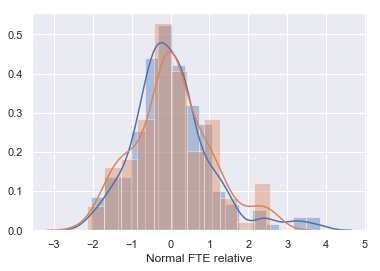

In [25]:
sns.distplot(dearx['Normal FTE relative'])
sns.distplot(deyex['Normal FTE relative'])

In [26]:
dearx=dearx[dearx['Normal FTE relative'] > 1]
deyex=deyex[deyex['Normal FTE relative'] > 1]
abilitiesx = abilities[abilities['Normal Weight']>1]

In [27]:
dearx.sort_values('Normal FTE relative',ascending=False)

,index,SOCP,Occupation,FTE relative,dear-FTE USmean,count,all count,relative count,Normal FTE relative,O*NET-SOC Code
2,48,132052,personal financial advisors,1.28,102740.0,216,14506,0.014890,3.834089,13-2052
30,176,299000,other healthcare practitioners and technical o...,1.26,65226.0,118,4596,0.025674,3.507213,29-9000
40,35,131081,logisticians,1.24,60790.0,128,5364,0.023863,3.180338,13-1081
154,207,352021,food preparation workers,1.24,34782.0,111,6656,0.016677,3.180338,35-2021
155,469,537064,"packers and packagers, hand",1.21,34742.0,176,7537,0.023351,2.690025,53-7064
13,69,171010,"architects, except naval",1.19,81644.0,113,7378,0.015316,2.363149,17-1010
136,383,512020,"electrical, electronics, and electromechanical...",1.19,37927.0,108,4345,0.024856,2.363149,51-2020
102,216,371011,first-line supervisors of housekeeping and jan...,1.19,44414.0,182,6843,0.026597,2.363149,37-1011
139,392,513099,"food processing workers, all other",1.15,37517.0,117,3928,0.029786,1.709398,51-3099
41,24,119151,social and community service managers,1.14,59047.0,287,16157,0.017763,1.545960,11-9151


In [28]:


def SOCQ(code):
     return not len(BM(abilities).select('O*NET-SOC Code','contains',code).df.values)==0

def shaveSOC(code):
    while not SOCQ(code):
        code = code[:-1]
    return code

#dearx['O*NET-SOC Code']=dearx['O*NET-SOC Code'].apply(shaveSOC)
#deyex['O*NET-SOC Code']=dearx['O*NET-SOC Code'].apply(shaveSOC)

In [29]:
def OccQ(code):
     return not len(BM(abilities).select('title','contains',code).df.values)==0

#dearx['O*NET-SOC Code']=dearx['O*NET-SOC Code'].apply(shaveSOC)
#deyex['O*NET-SOC Code']=dearx['O*NET-SOC Code'].apply(shaveSOC)

In [30]:
dearx['O*NET-SOC Code']=dearx['O*NET-SOC Code'].apply(shaveSOC)
deyex['O*NET-SOC Code']=deyex['O*NET-SOC Code'].apply(shaveSOC)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
dearx = dearx[dearx['O*NET-SOC Code'].apply(len) > 5]
deyex = deyex[deyex['O*NET-SOC Code'].apply(len) > 5]

In [32]:
deyex

,index,SOCP,Occupation,FTE relative,deye-FTE USmean,count,all count,relative count,Normal FTE relative,O*NET-SOC Code
5,73,172051,civil engineers,1.04,80353.0,104,12994,0.006856,1.061041,17-2051
18,51,132070,credit counselors and loan officers,1.07,59362.0,102,11981,0.007875,1.625644,13-207
31,129,271020,designers,1.04,51957.0,215,27198,0.007722,1.061041,27-102
51,367,499021,"heating, air conditioning, and refrigeration m...",1.07,46098.0,190,13344,0.014120,1.625644,49-9021
63,14,119013,"farmers, ranchers, and other agricultural mana...",1.12,41967.0,134,12689,0.010088,2.566651,11-9013
72,108,211093,social and human service assistants,1.05,38827.0,103,5501,0.017646,1.249242,21-1093
75,171,292050,health practitioner support technologists and ...,1.11,38071.0,220,18659,0.011654,2.378450,29-205
80,301,439021,data entry keyers,1.12,36572.0,162,10478,0.015029,2.566651,43-9021
81,449,533020,bus drivers,1.04,36434.0,174,13712,0.011806,1.061041,53-302
86,329,472140,painters and paperhangers,1.06,36132.0,144,10446,0.013200,1.437443,47-214


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


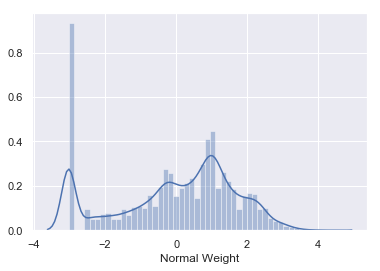

In [33]:
sns.distplot(abilities['Normal Weight'])

# PREDICTED ABILITIES

### PREDICTED STRENGTHS 

In [34]:
abidic = Counter()
abidic['DEAR'] = Counter()
abidic['DEYE'] = Counter()

In [35]:
for socc in dearx['O*NET-SOC Code']:
    abidic['DEAR'][socc]=Counter(BM(abilities).select('O*NET-SOC Code','contains',socc).select(
        'Normal Weight','gt',1.95).df.groupby('Element Name').median().index.values)

for socc in deyex['O*NET-SOC Code']:
    abidic['DEYE'][socc]=Counter(BM(abilities).select('O*NET-SOC Code','contains',socc).select(
        'Normal Weight','gt',1.95).df.groupby('Element Name').median().index.values)

In [36]:
absum=Counter()
absum['DEAR'] = Counter()
for cntr in list(abidic['DEAR'].values()):
    absum['DEAR'] += cntr
    
absum['DEYE'] = Counter()
for cntr in list(abidic['DEYE'].values()):
    absum['DEYE'] += cntr

In [37]:
dearabis = pd.DataFrame(list(absum['DEAR'].items()),columns=('Ability','Occupations'))
dearabis['Occupations'] = (dearabis['Occupations'] - dearabis['Occupations'].mean())/dearabis['Occupations'].std()
deyeabis = pd.DataFrame(list(absum['DEYE'].items()),columns=('Ability','Occupations'))
deyeabis['Occupations'] = (deyeabis['Occupations'] - deyeabis['Occupations'].mean())/deyeabis['Occupations'].std()

####  PREDICTED STRENGTHS OF THE AVERAGE PERSONA WITH HEARING DIFFICULTIES

In [38]:
yes_dear = dearabis[dearabis['Occupations']>1].sort_values('Occupations',ascending=False)
yes_dear

,Ability,Occupations
2,Near Vision,2.233965
4,Oral Comprehension,1.821745
5,Oral Expression,1.821745
0,Deductive Reasoning,1.615635
6,Problem Sensitivity,1.615635
8,Written Comprehension,1.203416


####  PREDICTED STRENGTHS OF THE AVERAGE PERSONA WITH DIFFICULTIES SEEING

In [39]:
yes_deye = deyeabis[deyeabis['Occupations']>1].sort_values('Occupations',ascending=False)
yes_deye

,Ability,Occupations
9,Oral Comprehension,2.338148
10,Oral Expression,2.051007
11,Problem Sensitivity,1.476725


### PREDICTED WEAKNESSES

In [40]:
noabidic = Counter()
noabidic['DEAR'] = Counter()
noabidic['DEYE'] = Counter()

In [41]:
for socc in dearx['O*NET-SOC Code']:
    noabidic['DEAR'][socc]=Counter(BM(abilities).select('O*NET-SOC Code','contains',socc).select(
        'Normal Weight','lt',-1).df.groupby('Element Name').median().index.values)

for socc in deyex['O*NET-SOC Code']:
    noabidic['DEYE'][socc]=Counter(BM(abilities).select('O*NET-SOC Code','contains',socc).select(
        'Normal Weight','lt',-1).df.groupby('Element Name').median().index.values)

In [42]:
noabsum=Counter()
noabsum['DEAR'] = Counter()
for cntr in list(noabidic['DEAR'].values()):
    noabsum['DEAR'] += cntr
    
noabsum['DEYE'] = Counter()
for cntr in list(noabidic['DEYE'].values()):
    noabsum['DEYE'] += cntr

In [43]:
dearnoabis = pd.DataFrame(list(noabsum['DEAR'].items()),columns=('Ability','Occupations'))
dearnoabis['Occupations'] = (dearnoabis['Occupations'] - dearnoabis['Occupations'].mean())/dearnoabis['Occupations'].std()
deyenoabis = pd.DataFrame(list(noabsum['DEYE'].items()),columns=('Ability','Occupations'))
deyenoabis['Occupations'] = (deyenoabis['Occupations'] - deyenoabis['Occupations'].mean())/deyenoabis['Occupations'].std()

####  PREDICTED WEAKNESSES OF THE AVERAGE PERSONA WITH HEARING DIFFICULTIES 

In [44]:
no_dear = dearnoabis[dearnoabis['Occupations']<-1].sort_values('Occupations')
no_dear

,Ability,Occupations
24,Visual Color Discrimination,-1.319629
26,Finger Dexterity,-1.319629
27,Hearing Sensitivity,-1.319629
31,Number Facility,-1.319629
32,Fluency of Ideas,-1.319629
1,Auditory Attention,-1.169980
29,Memorization,-1.169980
30,Originality,-1.169980
28,Mathematical Reasoning,-1.020331


####  PREDICTED WEAKNESSES OF THE AVERAGE PERSONA WITH DIFFICULTIES SEEING

In [159]:
no_deye = deyenoabis[deyenoabis['Occupations']<-1].sort_values('Occupations')
no_deye

,Ability,Occupations
25,Far Vision,-1.232971
29,Finger Dexterity,-1.232971
34,Fluency of Ideas,-1.232971
35,Originality,-1.232971
36,Written Expression,-1.232971
27,Visual Color Discrimination,-1.074016
28,Visualization,-1.074016


# OCCUPATION - MATCHING

## READ THIS FIRST

Very few high-value occupations have been designed for people with disabilities. The potential for innovating such occupations can be remarkable, considering the amount of unexplored enhanced abilities. The occupation matching here below includes only existing occupations that have been profiled by the DoL in the ONET database. 

**THE TABLES BELOW WILL THEREFORE UNDERESTIMATE THE LABOR MARKET VALUE OF PEOPLE WITH DISABILTIIES. MOST HIGH-VALUE JOBS REMAIN TO BE INNOVATED**

In [133]:
# BUILD THE ABILITIES-MATRIX FOR 
aaa = pd.get_dummies(abilities['Element Name']) 
abilitiesmat = abilities[['Title']].join(aaa.multiply(abilities['Normal Weight'],axis = "index")).groupby('Title').sum()

## SOME EXISTING OCCUPATIONS THAT CAN FIT PEOPLE WITH HEARING CHALLENGES. 
**THE SCORE MARKS THE SQUARED DISTANCE TO THE AVERAGE PERSONA** 

NOTE: PEOPLE ARE DIFFERENT. THIS SHOWS THE FIT WITH THE AVERAGE PERSON (AND NOBODY IS THE EXACT AVERAGE)

### WITH ASSISTIVE TECHNOLOGY
PREDICTED WEAKNESSES ARE EXCLUDED FROM THE MATCHING

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


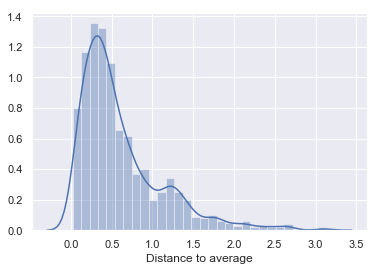

In [150]:
aaa = (abilitiesmat[yes_dear['Ability'].values] - yes_dear['Occupations'].values)**2 / len(yes_dear)
match_dear = pd.DataFrame(aaa.sum(axis=1).sort_values())
match_dear.columns = ['Distance to average']
sns.distplot(match_dear['Distance to average'])

In [145]:
match_dear[match_dear['Distance to average']<0.05]

,Distance to average
Title,
Manufactured Building and Mobile Home Installers,0.021281
Millwrights,0.021588
Embalmers,0.022121
Fabric and Apparel Patternmakers,0.027454
Heating and Air Conditioning Mechanics and Installers,0.029771
Phlebotomists,0.031299
"Camera Operators, Television, Video, and Motion Picture",0.033853
Mechanical Drafters,0.034369
Recreational Vehicle Service Technicians,0.042360


### NO ASSISTIVE TECHNOLOGY
PREDICTED WEAKNESSES ARE INCLUDED IN THE MATCHING

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


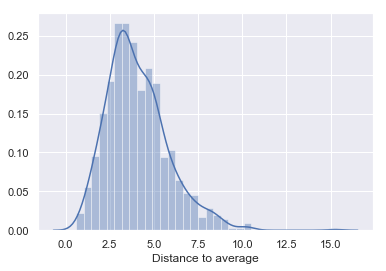

In [146]:
aaa = (abilitiesmat[yes_dear['Ability'].values] - yes_dear['Occupations'].values)**2 / len(yes_dear)
bbb = (abilitiesmat[no_dear['Ability'].values] - no_dear['Occupations'].values)**2 / len(no_dear)
ccc = aaa.join(bbb)
match_dear = pd.DataFrame(ccc.sum(axis=1).sort_values())
match_dear.columns = ['Distance to average']
sns.distplot(match_dear['Distance to average'])

In [148]:
match_dear[match_dear['Distance to average']<1.1]

,Distance to average
Title,
Bailiffs,0.595617
Court Clerks,0.741708
Proofreaders and Copy Markers,0.784232
Funeral Attendants,0.803371
"Stock Clerks- Stockroom, Warehouse, or Storage Yard",0.871035
"Title Examiners, Abstractors, and Searchers",0.912417
Gaming Surveillance Officers and Gaming Investigators,0.990398
Amusement and Recreation Attendants,0.997928
Credit Checkers,1.016457


## SOME EXISTING OCCUPATIONS THAT CAN FIT PEOPLE WITH SEEING CHALLENGES. 
**THE SCORE MARKS THE SQUARED DISTANCE TO THE AVERAGE PERSONA** 

NOTE: PEOPLE ARE DIFFERENT. THIS SHOWS THE FIT WITH THE AVERAGE PERSON (AND NOBODY IS THE EXACT AVERAGE)

### WITH ASSISTIVE TECHNOLOGY
PREDICTED WEAKNESSES ARE EXCLUDED FROM THE MATCHING

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


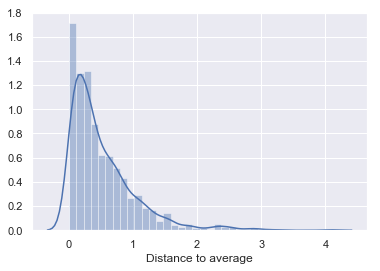

In [152]:
aaa = (abilitiesmat[yes_deye['Ability'].values] - yes_deye['Occupations'].values)**2 / len(yes_deye)
match_deye = pd.DataFrame(aaa.sum(axis=1).sort_values())
match_deye.columns = ['Distance to average']
sns.distplot(match_deye['Distance to average'])

In [154]:
match_deye[match_deye['Distance to average']<0.02]

,Distance to average
Title,
Cartographers and Photogrammetrists,0.006245
Photographers,0.007162
Athletes and Sports Competitors,0.010795
Statistical Assistants,0.011407
Food Science Technicians,0.011964
Data Warehousing Specialists,0.014076
"Musicians, Instrumental",0.014411
Customer Service Representatives,0.015079
Ophthalmic Medical Technicians,0.015424


### NO ASSISTIVE TECHNOLOGY
PREDICTED WEAKNESSES ARE INCLUDED IN THE MATCHING

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


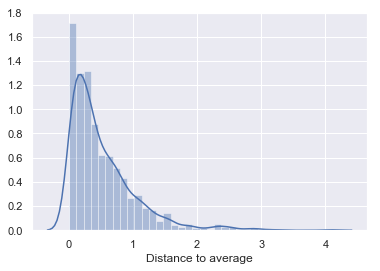

In [157]:
aaa = (abilitiesmat[yes_deye['Ability'].values] - yes_deye['Occupations'].values)**2 / len(yes_deye)
bbb = (abilitiesmat[no_deye['Ability'].values] - no_deye['Occupations'].values)**2 / len(no_deye)
ccc = aaa.join(bbb)
match_dear = pd.DataFrame(ccc.sum(axis=1).sort_values())
match_dear.columns = ['Distance to average']
sns.distplot(match_deye['Distance to average'])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,Distance to average
Title,
Cartographers and Photogrammetrists,0.006245
Photographers,0.007162
Athletes and Sports Competitors,0.010795
Statistical Assistants,0.011407
Food Science Technicians,0.011964
Data Warehousing Specialists,0.014076
"Musicians, Instrumental",0.014411
Customer Service Representatives,0.015079
Ophthalmic Medical Technicians,0.015424


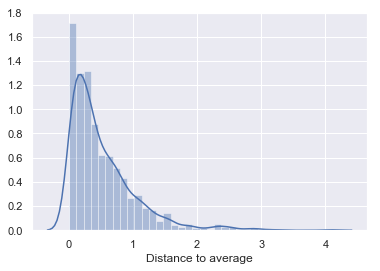

In [156]:
match_deye[match_deye['Distance to average']<1.1]